Final negative log likelihood: 296.5983219263583
Initial negative log likelihood: 392.94231185701346
Gradient of the negative log likelihood, wrt the parameters:
{'log_alpha': DeviceArray(3.3025811, dtype=float64), 'log_amps': DeviceArray([-56.37950097,   1.71669126,   4.11084749,  -2.13098285], dtype=float64), 'log_diag': DeviceArray(60.28268107, dtype=float64), 'log_gamma': DeviceArray(12.52278878, dtype=float64), 'log_period': DeviceArray(2339.70173767, dtype=float64), 'log_scales': DeviceArray([117.65693454,  -3.10865356, -27.13290445,  -4.04980878], dtype=float64), 'mean': DeviceArray(-0.15787706, dtype=float64)}


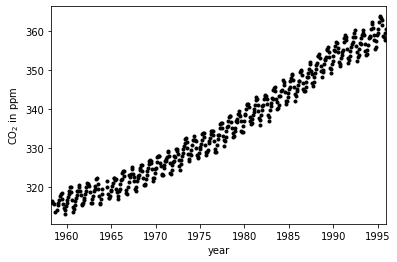

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.datasets import co2
import jax
import jax.numpy as jnp
import jaxopt
from tinygp import kernels, GaussianProcess

jax.config.update("jax_enable_x64", True)

data = co2.load_pandas().data
t = 2000 + (np.array(data.index.to_julian_date()) - 2451545.0) / 365.25
y = np.array(data.co2)
m = np.isfinite(t) & np.isfinite(y) & (t < 1996)
t, y = t[m][::4], y[m][::4]


def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    amps = jnp.exp(theta["log_amps"])
    scales = jnp.exp(theta["log_scales"])

    # Construct the kernel by multiplying and adding `Kernel` objects
    k1 = amps[0] * kernels.ExpSquared(scales[0])
    k2 = (
        amps[1]
        * kernels.ExpSquared(scales[1])
        * kernels.ExpSineSquared(
            scale=jnp.exp(theta["log_period"]),
            gamma=jnp.exp(theta["log_gamma"]),
        )
    )
    k3 = amps[2] * kernels.RationalQuadratic(
        alpha=jnp.exp(theta["log_alpha"]), scale=scales[2]
    )
    k4 = amps[3] * kernels.ExpSquared(scales[3])
    kernel = k1 + k2 + k3 + k4

    return GaussianProcess(
        kernel, X, diag=jnp.exp(theta["log_diag"]), mean=theta["mean"]
    )


def neg_log_likelihood(theta, X, y):
    gp = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    "mean": np.float64(340.0),
    "log_diag": np.log(0.19),
    "log_amps": np.log([66.0, 2.4, 0.66, 0.18]),
    "log_scales": np.log([67.0, 90.0, 0.78, 1.6]),
    "log_period": np.float64(0.0),
    "log_gamma": np.log(4.3),
    "log_alpha": np.log(1.2),
}

solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, X=t, y=y)
print(f"Final negative log likelihood: {soln.state.fun_val}")
gp = build_gp(soln.params, t)


import numpy as np
import matplotlib.pyplot as plt
from statsmodels.datasets import co2

data = co2.load_pandas().data
t = 2000 + (np.array(data.index.to_julian_date()) - 2451545.0) / 365.25
y = np.array(data.co2)
m = np.isfinite(t) & np.isfinite(y) & (t < 1996)
t, y = t[m][::4], y[m][::4]

plt.plot(t, y, ".k")
plt.xlim(t.min(), t.max())
plt.xlabel("year")
_ = plt.ylabel("CO$_2$ in ppm")



# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

x = np.linspace(1966, 2026, 2000)
gp = build_gp(soln.params, t)
cond_gp = gp.condition(y, x).gp
mu, var = cond_gp.loc, cond_gp.variance



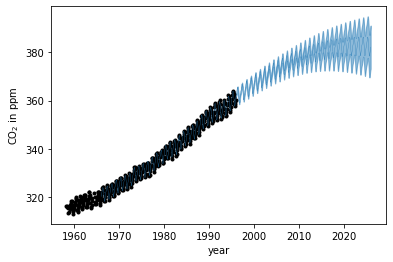

In [30]:
plt.plot(t, y, ".k")
plt.fill_between(
    x, mu + np.sqrt(var), mu - np.sqrt(var), color="C0", alpha=0.5
)
plt.plot(x, mu, color="C0", lw=0.3)

# plt.xlim(1980, 2025)
# plt.ylim(330, 405)
# plt.xticks(np.arange(2022, 2026, step=1)) 
# plt.yticks(np.arange(360, 410, step=10))
plt.xlabel("year")
_ = plt.ylabel("CO$_2$ in ppm")




In [58]:
from nde import distributions, flows, transforms
import nn as nn_


import torch
import numpy as np
from torch.distributions.normal import Normal
import torch.optim as optim
import torch.nn as nn
from nde.flows import realnvp
import tqdm
import matplotlib.pyplot as plt
from nde.flows import autoregressive as ar
from torch.nn.utils import clip_grad_norm_

from scipy.stats import norm



num_flow_steps=2
dim=2
hidden_features=64
num_transform_blocks=2
dropout_probability=0.0
use_batch_norm=0
num_bins=128
learning_rate = 5e-4
n_total_steps = 1e3


distribution = distributions.TweakedUniform(
    low=torch.zeros(dim),
    high=torch.ones(dim)
)

distribution = distributions.StandardNormal((2,))

def create_alternating_binary_mask(features, even=True):
    """
    Creates a binary mask of a given dimension which alternates its masking.

    :param features: Dimension of mask.
    :param even: If True, even values are assigned 1s, odd 0s. If False, vice versa.
    :return: Alternating binary mask of type torch.Tensor.
    """
    mask = torch.zeros(features).byte()
    start = 0 if even else 1
    mask[start::2] += 1
    return mask

base_transform_type = 'rq'
def create_base_transform(i, _tail_bound):
    if base_transform_type == 'rq':
        return transforms.PiecewiseRationalQuadraticCouplingTransform(
            mask=create_alternating_binary_mask(
                features=dim,
                even=(i % 2 == 0)
            ),
            transform_net_create_fn=lambda in_features, out_features:
            nn_.ResidualNet(
                in_features=in_features,
                out_features=out_features,
                hidden_features=hidden_features,
                num_blocks=num_transform_blocks,
                dropout_probability=dropout_probability,
                use_batch_norm=use_batch_norm
            ),
            num_bins=num_bins,
            apply_unconditional_transform=False,
            tails='linear',
            tail_bound=_tail_bound,
        )
    elif base_transform_type == 'affine':
        return transforms.AffineCouplingTransform(
            mask=create_alternating_binary_mask(
                features=dim,
                even=(i % 2 == 0)
            ),
            transform_net_create_fn=lambda in_features, out_features:
            nn_.ResidualNet(
                in_features=in_features,
                out_features=out_features,
                hidden_features=hidden_features,
                num_blocks=num_transform_blocks,
                dropout_probability=dropout_probability,
                use_batch_norm=use_batch_norm
            )
        )
    else:
        raise ValueError
        
        


## =================
device = torch.device("cpu")
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = torch.device("cuda:0")
print("==run on=> ", device)



==run on=>  cpu


100 tensor(0.0146) 1.5932340621948242
200 tensor(0.0042) 1.5638657808303833
300 tensor(0.0156) 1.5362733602523804
400 tensor(0.0122) 1.5332145690917969
500 tensor(0.0059) 1.5278031826019287
600 tensor(-0.0070) 1.5210644006729126
700 tensor(0.0014) 1.523376703262329
800 tensor(-0.0284) 1.516648292541504
900 tensor(0.0049) 1.5136818885803223
1000 tensor(-0.0031) 1.5135780572891235
===> tensor(-0.0031) 1.5131232738494873


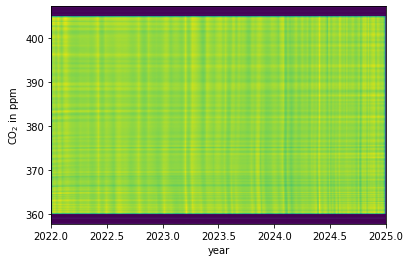

In [9]:
def plotDensity(dd=300j):
    with torch.no_grad():
        _ = flow.eval()
        ddi = int(dd.imag)
        X, Y = np.mgrid[-1:1:dd, -1.1:1.1:dd]
        _z = torch.FloatTensor(np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1))
        with torch.no_grad():
            z = flow.log_prob(_z).exp().reshape(ddi, ddi)
        # plt.figure(figsize = (20,20))
        plt.imshow(z.T, origin='lower', extent=[2022,2025,357.75,407.25], aspect="auto")
        plt.xticks(np.arange(2022, 2026, step=1)) 
        plt.yticks(np.arange(360, 410, step=10))
        plt.xlabel("year")
        plt.ylabel("CO$_2$ in ppm")
        plt.show()

def logf(x):
    xx = x[:,0].cpu().numpy()*1.5 + 2023.5
    cond_gp = gp.condition(y, xx).gp  ### <<<<==============
    mu, var = np.asarray(cond_gp.loc), np.asarray(cond_gp.variance)
    return -(torch.log(2*torch.pi*torch.FloatTensor(var)) + (x[:,1]*22.5 + 382.5 - mu)**2 / var )/2   \
             + torch.log(x[:,0]>-1) + torch.log(x[:,0]<1) + torch.log(x[:,1]>-1)   

def calLoss(inputs, log_prob):
    return - ((logf(inputs) - log_prob).exp() * log_prob).mean()

def survey_sample(n):
    x = np.random.uniform(size=n, low =-1, high=1)
    y = np.random.uniform(size=n, low =-1, high=1)
    return torch.FloatTensor(np.concatenate([x.reshape(n, 1), y.reshape(n, 1)], axis=1))

transform = transforms.CompositeTransform(
    [create_base_transform(i, 2) for i in range(num_flow_steps)])
flow = flows.Flow(transform, distributions.StandardNormal((2,))).to(device)

optimizer_servy = optim.Adam(flow.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_servy, n_total_steps)

history = []
for epoch in range(1000): #tqdm.notebook.tqdm(, desc='Survey', leave=False):
    with torch.no_grad():
        inputs = survey_sample(2000).to(device)
        if(epoch % 100 == 99):
            print(epoch+1, inputs[:,0].mean(), loss.item())

    _ = flow.train()
    optimizer_servy.zero_grad()

    log_prob = flow.log_prob(inputs)
    loss = -torch.mean(log_prob) # calLoss(inputs, log_prob)
    loss.backward()
    optimizer_servy.step()
    scheduler.step()
    # history.append(loss.item())
print("===>", inputs[:,0].mean(), loss.item())
plotDensity()

100 tensor(0.0111) 0.11167339157419638
200 tensor(0.0093) 0.10976918473224052
300 tensor(0.0032) 0.10502743337992136
400 tensor(0.0143) 0.10352263180495216
500 tensor(0.0019) 0.10667535984424853
600 tensor(0.0062) 0.10149777286910174
700 tensor(0.0117) 0.10649232903858913
800 tensor(-0.0173) 0.10522120454461331
900 tensor(0.0288) 0.10425354469037679
1000 tensor(0.0073) 0.1031985551583193


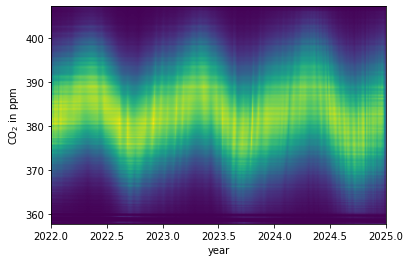

In [10]:
optimizer_refine = optim.Adam(flow.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_refine, n_total_steps)  
for epoch in range(1000): #tqdm.notebook.tqdm(, desc='Refine', leave=False):
    with torch.no_grad():
        _ = flow.eval()
        inputs = flow.sample(1500).detach()
        # inputs  = filterInputs(inputs)
        if(epoch % 100 == 99):
            print(epoch+1, inputs[:,0].mean(), loss.item())

    _ = flow.train()
    # scheduler.step(epoch)
    optimizer_refine.zero_grad()

    log_prob = flow.log_prob(inputs)
    loss = calLoss(inputs, log_prob)
    loss.backward()
    optimizer_refine.step()
    history.append(loss.item())

plotDensity()


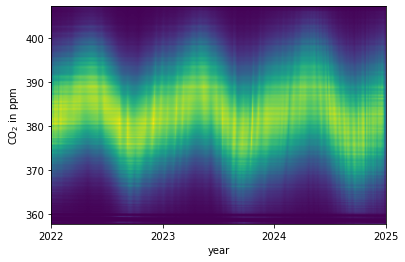

In [17]:


plotDensity()

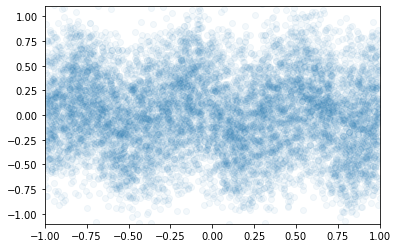

real: 3.0000000000,
mean: 2.9863038472,
 std: 0.0040217394, 
accuracy: 99.543%


In [13]:
def calIntegral(needprint=False, n_sample = 5000 ):
    with torch.no_grad():
        _ = flow.eval()
        x, loggx = flow.sample_and_log_prob(n_sample)
        x = x.cpu()
        loggx=loggx.cpu()
        s0, s1 = x[:,0], x[:,1]

        intgral = torch.exp(logf(x) - loggx).mean()

        if(needprint):
            plt.scatter(s0, s1, marker='o', alpha=0.05)
            # plt.plot(0, 0, 'rp', markersize=5)
            plt.xlim([-1, 1])
            plt.ylim([-1.1, 1.1])
            plt.show()
        return intgral


v = [calIntegral(i==0, 10000)* 1.5 *22.5  for i in range(10)]
real = 3
print("real: %.10f,\nmean: %.10f,\n std: %.10f, \naccuracy: %.3f%%" % (real, np.mean(v),
                                np.std(v), (1-np.abs(np.mean(v) - real)/real)*100))


